<a href="https://colab.research.google.com/github/tuyenpham654/DA_Learning/blob/main/Credit_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [ ]:
from google.colab import files

# Chạy lệnh upload
uploaded = files.upload()

Saving data.csv to data (1).csv


In [ ]:
df = pd.read_csv('data.csv')

**Làm sạch dữ liệu**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

In [ ]:
#loại bỏ nhưng cột không có giá trị
cols_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
data = df.drop(columns=cols_to_drop)


In [ ]:
# mã hóa cho để cột hành vi thành số để có thể đưa vào mô hình
le_payment = LabelEncoder()

# Mã hoá và gán vào chính cột đó
data['Payment_Behaviour'] = le_payment.fit_transform(data['Payment_Behaviour'].astype(str))

In [ ]:
#đưa tuổi về với giá trị thực tế hơn

def clean_age_column(series):
    cleaned = series.astype(str).str.replace(r'[^\d]', '', regex=True)
    cleaned = pd.to_numeric(cleaned, errors='coerce')
    cleaned = cleaned.where((cleaned >= 16) & (cleaned <= 120), np.nan)
    return cleaned

data['Age'] = clean_age_column(data['Age'])
print(data['Age'].unique())
data['Age'] = data['Age'].fillna(data['Age'].median())

[ 23.  24.  28.  35.  55.  22.  31.  32.  nan  34.  30.  45.  41.  33.
  36.  39.  40.  37.  21.  46.  26.  27.  42.  20.  48.  49.  38.  44.
  16.  17.  19.  43.  25.  18.  47.  29.  53.  56.  54.  50.  51.  52.
  95. 120.]


In [ ]:
# mã hóa cột cột nghê nghiệp
data['Occupation'] = data['Occupation'].replace('_______', 'unknown')
occupation_encoder = LabelEncoder()
data['Occupation'] = occupation_encoder.fit_transform(data['Occupation'])
print(data['Occupation'].unique())

[12 15 13  4  5  2  7 10  3  6  8  0 11  9 14  1]


In [ ]:
def to_float(series):
    # Bỏ các ký tự không phải số, dấu chấm hoặc dấu trừ
    series = series.astype(str).str.replace(r'[^\d\.\-]', '', regex=True)

    #Chuyển về float, lỗi thì trả NaN
    return pd.to_numeric(series, errors='coerce')
data['Annual_Income'] = to_float(data['Annual_Income'])
data['Annual_Income'].describe()

,Annual_Income
count,5.000000e+04
mean,1.663342e+05
std,1.351965e+06
min,7.005930e+03
25%,1.945333e+04
50%,3.757782e+04
75%,7.281702e+04
max,2.413726e+07


In [ ]:
# xử lý dữ liệu ngoại lai bằng IQR
Q1 = data['Annual_Income'].quantile(0.25)
Q3 = data['Annual_Income'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
print("Upper Bound:", upper_bound)
data.loc[data['Annual_Income'] > upper_bound, 'Annual_Income'] = np.nan
data['Annual_Income'] = data['Annual_Income'].fillna(data['Annual_Income'].median())
data['Annual_Income'].describe()

Upper Bound: 152862.55875000003


,Annual_Income
count,50000.000000
mean,48019.870740
std,34728.383551
min,7005.930000
25%,19453.327500
50%,36401.360000
75%,68665.760000
max,152796.760000


In [ ]:
# điền vào những chỗ trống dựa vào thu nhập năm
data.loc[data['Monthly_Inhand_Salary'].isna(), 'Monthly_Inhand_Salary'] = \
    data['Annual_Income'] / 12


print(data['Monthly_Inhand_Salary'].describe())

count    50000.000000
mean      4156.044257
std       3135.495403
min        303.645417
25%       1624.751667
50%       3062.342500
75%       5909.621250
max      15204.633333
Name: Monthly_Inhand_Salary, dtype: float64


In [ ]:
# Đổi giá trị âm thành NaN
data.loc[data['Num_Bank_Accounts'] < 0, 'Num_Bank_Accounts'] = np.nan

#số lượng tài khoản tối đa là 40
max_valid = 40
data.loc[data['Num_Bank_Accounts'] > max_valid, 'Num_Bank_Accounts'] = np.nan

# Sau đó, có thể điền NaN bằng median
median_val = data['Num_Bank_Accounts'].median()
data['Num_Bank_Accounts'] = data['Num_Bank_Accounts'].fillna(median_val)

In [ ]:
#số lượng thẻ hợp lý
max_valid = 20
data.loc[data['Num_Credit_Card'] > max_valid, 'Num_Credit_Card'] = np.nan
data.loc[data['Num_Credit_Card'] < 0, 'Num_Credit_Card'] = np.nan
median_val = data['Num_Credit_Card'].median()
data['Num_Credit_Card'] = data['Num_Credit_Card'].fillna(median_val)


In [ ]:
# đưa lãi xuất về giá trị thực tế hơn
data['Interest_Rate'] = np.where(data['Interest_Rate'] >= 100,
                                data['Interest_Rate'] / 100,
                                data['Interest_Rate'])

# Kiểm tra lại giá trị sau xử lý
print(data['Interest_Rate'].describe())

count    50000.000000
mean        14.800691
std          9.177286
min          1.000000
25%          7.000000
50%         13.000000
75%         20.000000
max         89.000000
Name: Interest_Rate, dtype: float64


In [ ]:
#loại bỏ các ký tự đặc biệt và đưa cột về kiểu số
data['Num_of_Loan'] = data['Num_of_Loan'].str.replace(r'[^0-9\-]', '', regex=True)
data['Num_of_Loan'] = data['Num_of_Loan'].str.lstrip('-')
data['Num_of_Loan'] = pd.to_numeric(data['Num_of_Loan'], errors='coerce')
print(data['Num_of_Loan'].describe())

count    50000.000000
mean        11.299360
std         65.483498
min          0.000000
25%          2.000000
50%          3.000000
75%          6.000000
max       1496.000000
Name: Num_of_Loan, dtype: float64


In [ ]:
# Giới hạn tối đa là 20 khoản vay
data.loc[data['Num_of_Loan'] > 20, 'Num_of_Loan'] = 20
Q1 = data['Num_of_Loan'].quantile(0.25)
Q3 = data['Num_of_Loan'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Cắt những giá trị quá lớn
data.loc[data['Num_of_Loan'] > upper_bound, 'Num_of_Loan'] = upper_bound

In [ ]:
# Làm sạch danh sách loại khoản vay
def clean_loan_types(entry):
    if pd.isnull(entry):
        return []
    types = [x.strip() for x in entry.split(',') if x.strip() != 'Not Specified']
    return list(set(types))  # loại bỏ trùng lặp

# Áp dụng làm sạch
data['Cleaned_Loan_Types'] = data['Type_of_Loan'].apply(clean_loan_types)

# Mã hóa one-hot
mlb = MultiLabelBinarizer()
loan_dummies = pd.DataFrame(
    mlb.fit_transform(data['Cleaned_Loan_Types']),
    columns=mlb.classes_,
    index=data.index
)

# Ghép dữ liệu và xóa cột cũ
data = pd.concat([data.drop(columns=['Type_of_Loan', 'Cleaned_Loan_Types']), loan_dummies], axis=1)


In [ ]:
#  Loại bỏ ký tự không phải số và dấu trừ
data['Delay_from_due_date'] = data['Delay_from_due_date'].astype(str).str.replace(r'[^0-9\-]', '', regex=True)

#   Loại bỏ dấu trừ đầu
data['Delay_from_due_date'] = data['Delay_from_due_date'].str.lstrip('-')

# Ép kiểu về số
data['Delay_from_due_date'] = pd.to_numeric(data['Delay_from_due_date'], errors='coerce')

print(data['Delay_from_due_date'].describe())


count    50000.000000
mean        21.080880
std         14.820308
min          0.000000
25%         10.000000
50%         18.000000
75%         28.000000
max         67.000000
Name: Delay_from_due_date, dtype: float64


In [ ]:
# Loại bỏ dấu gạch dưới cuối chuỗi
data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].astype(str).str.rstrip('_')

# Loại bỏ dấu trừ ở đầu (nếu có)
data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].str.lstrip('-')

# Ép kiểu về số (int), các giá trị lỗi sẽ thành NaN
data['Num_of_Delayed_Payment'] = pd.to_numeric(data['Num_of_Delayed_Payment'], errors='coerce')


# thay NaN bằng 0 (không trễ)
data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].fillna(0).astype(int)

# Giảm ảnh hưởng của các giá trị quá lớn (outliers) mà không loại bỏ dữ liệu
upper_limit = data['Num_of_Delayed_Payment'].quantile(0.99)
data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].clip(upper=upper_limit)
data['Num_of_Delayed_Payment'].describe()

,Num_of_Delayed_Payment
count,50000.000000
mean,12.517780
std,7.023036
min,0.000000
25%,8.000000
50%,13.000000
75%,18.000000
max,27.000000


In [ ]:
# loại bỏ dấu '-' ở đầu chuỗi
data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].astype(str).str.lstrip('-')

# chuyển về kiểu số
data['Changed_Credit_Limit'] = pd.to_numeric(data['Changed_Credit_Limit'], errors='coerce')
data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].fillna(data['Changed_Credit_Limit'].median())

data['Changed_Credit_Limit'].describe()


,Changed_Credit_Limit
count,50000.000000
mean,10.435855
std,6.582483
min,0.000000
25%,5.480000
50%,9.410000
75%,14.600000
max,36.650000


In [ ]:
# Tính trung vị từ các giá trị hợp lệ
median_inquiries = data.loc[data['Num_Credit_Inquiries'] <= 100, 'Num_Credit_Inquiries'].median()

# Gán trung vị cho các giá trị bất hợp lệ
data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].apply(
    lambda x: x if x <= 100 else median_inquiries
)

In [ ]:
# loại bỏ ký tự đặc biệt
data['Outstanding_Debt'] = data['Outstanding_Debt'].str.replace('[^\d\.]', '', regex=True)

# Chuyển đổi sang kiểu float
data['Outstanding_Debt'] = data['Outstanding_Debt'].astype(float)

In [ ]:
# chuyển cột tuổi của tài khoản đó từ năm thành tháng
def convert_to_months(text):
    if pd.isna(text):
        return np.nan
    try:
        text = text.strip()
        if 'and' in text:
            parts = text.split('and')
            years = int(parts[0].strip().replace('Years', '').strip())
            months = int(parts[1].strip().replace('Months', '').strip())
        elif 'Years' in text:
            years = int(text.replace('Years', '').strip())
            months = 0
        elif 'Months' in text:
            years = 0
            months = int(text.replace('Months', '').strip())
        else:
            return np.nan
        return years * 12 + months
    except:
        return np.nan

# Áp dụng chuyển đổi
data['Credit_History_Age'] = data['Credit_History_Age'].apply(convert_to_months)

# Điền NA bằng median
data['Credit_History_Age'] = data['Credit_History_Age'].fillna(data['Credit_History_Age'].median())


In [ ]:
# mã hóa cột Thanh toán số tiền tối thiểu và bỏ No Mention vì không có giá trị
data['Payment_of_Min_Amount'] = data['Payment_of_Min_Amount'].map({
    'No': 0,
    'Yes': 1,
    'NM': np.nan  # bỏ đi vì không có giá trị để tính
})

In [ ]:
# Giảm ảnh hưởng của các giá trị quá lớn (outliers) mà không loại bỏ dữ liệu
upper_limit = data['Total_EMI_per_month'].quantile(0.95)  # 95th percentile
data['Total_EMI_per_month'] = data['Total_EMI_per_month'].clip(upper=upper_limit)

In [ ]:
# loại bỏ dấu '-' ở đầu chuỗi
data['Amount_invested_monthly'] = data['Amount_invested_monthly'].astype(str).str.lstrip('-')

# chuyển về kiểu số (float)
data['Amount_invested_monthly'] = pd.to_numeric(data['Amount_invested_monthly'], errors='coerce')
data['Amount_invested_monthly'] = data['Amount_invested_monthly'].fillna(data['Amount_invested_monthly'].median())


# Kiểm tra kết quả
print(data['Amount_invested_monthly'].describe())

count    50000.000000
mean       188.984370
std        188.639765
min          0.000000
25%         77.031011
50%        129.032119
75%        220.559195
max       1908.124400
Name: Amount_invested_monthly, dtype: float64


In [ ]:
# Thay giá trị bất thường bằng NaN
data['Payment_Behaviour'] = data['Payment_Behaviour'].replace('!@9#%8', np.nan)
data['Payment_Behaviour'].describe()

,Payment_Behaviour
count,50000.000000
mean,3.459960
std,2.033568
min,0.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,6.000000


In [ ]:
# Thay thế giá trị placeholder lỗi thành NaN
data['Monthly_Balance'] = data['Monthly_Balance'].replace('__-333333333333333333333333333__', np.nan)

# Chuyển sang số, lỗi chuyển thành NaN
data['Monthly_Balance'] = pd.to_numeric(data['Monthly_Balance'], errors='coerce')


# Xử lý NaN: ví dụ điền bằng median
median_balance = data['Monthly_Balance'].median()
data['Monthly_Balance'] = data['Monthly_Balance'].fillna(median_balance)
data['Monthly_Balance'].describe()

,Monthly_Balance
count,50000.000000
mean,402.315569
std,212.583269
min,0.103402
25%,271.118562
50%,336.984582
75%,468.571215
max,1606.518192


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          50000 non-null  float64
 1   Occupation                   50000 non-null  int64  
 2   Annual_Income                50000 non-null  float64
 3   Monthly_Inhand_Salary        50000 non-null  float64
 4   Num_Bank_Accounts            50000 non-null  float64
 5   Num_Credit_Card              50000 non-null  float64
 6   Interest_Rate                50000 non-null  float64
 7   Num_of_Loan                  50000 non-null  int64  
 8   Delay_from_due_date          50000 non-null  int64  
 9   Num_of_Delayed_Payment       50000 non-null  int64  
 10  Changed_Credit_Limit         50000 non-null  float64
 11  Num_Credit_Inquiries         50000 non-null  float64
 12  Credit_Mix                   50000 non-null  object 
 13  Outstanding_Debt

In [ ]:
data.head()


,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Student Loan,and Auto Loan,and Credit-Builder Loan,and Debt Consolidation Loan,and Home Equity Loan,and Mortgage Loan,and Not Specified,and Payday Loan,and Personal Loan,and Student Loan
0,23.0,12,19114.12,1824.843333,3.0,4.0,3.0,4,3,7,...,0,0,0,0,1,0,0,0,0,0
1,24.0,12,19114.12,1824.843333,3.0,4.0,3.0,4,3,9,...,0,0,0,0,1,0,0,0,0,0
2,24.0,12,19114.12,1824.843333,3.0,4.0,3.0,4,1,4,...,0,0,0,0,1,0,0,0,0,0
3,24.0,12,19114.12,1592.843333,3.0,4.0,3.0,4,4,5,...,0,0,0,0,1,0,0,0,0,0
4,28.0,15,34847.84,3037.986667,2.0,4.0,6.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data['Credit_Mix'].unique()

array(['Good', '_', 'Standard', 'Bad'], dtype=object)

In [ ]:
  # Dữ liệu có giá trị Credit_Mix là '_' -> Tập cần dự đoán
data_unknown = data[data['Credit_Mix'] == '_'].copy()

# Dữ liệu có nhãn (không phải '_') -> Dùng để huấn luyện mô hình
data_known = data[data['Credit_Mix'] != '_'].copy()

In [ ]:
print(data_unknown['Credit_Mix'].count())

9805


In [ ]:
print(data_known['Credit_Mix'].count())

40195


dùng random forest để phân lớp tìm các điểm dữ liệu bị mất của cột Credit_Mix

In [ ]:
print(data_known)

        Age  Occupation  Annual_Income  Monthly_Inhand_Salary  \
0      23.0          12       19114.12            1824.843333   
1      24.0          12       19114.12            1824.843333   
2      24.0          12       19114.12            1824.843333   
3      24.0          12       19114.12            1592.843333   
4      28.0          15       34847.84            3037.986667   
...     ...         ...            ...                    ...   
49993  29.0           1       20002.88            1929.906667   
49994  29.0          15       20002.88            1929.906667   
49996  25.0           9       39628.99            3302.415833   
49997  25.0           9       39628.99            3359.415833   
49998  25.0           9       39628.99            3302.415833   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
0                    3.0              4.0            3.0            4   
1                    3.0              4.0            3.0            4   


In [ ]:
data_known.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40195 entries, 0 to 49998
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          40195 non-null  float64
 1   Occupation                   40195 non-null  int64  
 2   Annual_Income                40195 non-null  float64
 3   Monthly_Inhand_Salary        40195 non-null  float64
 4   Num_Bank_Accounts            40195 non-null  float64
 5   Num_Credit_Card              40195 non-null  float64
 6   Interest_Rate                40195 non-null  float64
 7   Num_of_Loan                  40195 non-null  int64  
 8   Delay_from_due_date          40195 non-null  int64  
 9   Num_of_Delayed_Payment       40195 non-null  int64  
 10  Changed_Credit_Limit         40195 non-null  float64
 11  Num_Credit_Inquiries         40195 non-null  float64
 12  Credit_Mix                   40195 non-null  object 
 13  Outstanding_Debt     

In [ ]:
# X là tập đặc trưng, y là nhãn
X = data_known.drop(columns=['Credit_Mix'])
y = data_known['Credit_Mix']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Grid các tham số cho RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Khởi tạo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Tìm kiếm tham số tối ưu
grid = GridSearchCV(rf, param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best parameters:", grid.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  14.9s
[CV] END ma

In [ ]:
model = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9743749222540117

In [ ]:
# 1. bỏ cột Credit_Mix để tiến hành dự đoán
X_missing = data_unknown.drop(columns=['Credit_Mix'])

# 2. dự đoán mô hình bằng model đã training
y_pred_missing = model.predict(X_missing)

# 3. gán lại cột Credit_Mix
data_unknown['Credit_Mix'] = y_pred_missing

data_full = pd.concat([data_unknown, data_known]).sort_index()

In [ ]:
# Lấy độ quan trọng của từng cột
importances = model.feature_importances_

# Tạo DataFrame để hiển thị gọn gàng
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Hiển thị bảng độ quan trọng
print(feature_importance_df)

                        Feature  Importance
6                 Interest_Rate    0.147821
15        Payment_of_Min_Amount    0.122538
12             Outstanding_Debt    0.114547
4             Num_Bank_Accounts    0.105824
9        Num_of_Delayed_Payment    0.103970
8           Delay_from_due_date    0.092933
10         Changed_Credit_Limit    0.056379
7                   Num_of_Loan    0.044235
14           Credit_History_Age    0.039162
5               Num_Credit_Card    0.029244
11         Num_Credit_Inquiries    0.027959
3         Monthly_Inhand_Salary    0.015157
2                 Annual_Income    0.015060
19              Monthly_Balance    0.012779
0                           Age    0.011033
16          Total_EMI_per_month    0.010809
17      Amount_invested_monthly    0.008231
13     Credit_Utilization_Ratio    0.008002
1                    Occupation    0.007099
18            Payment_Behaviour    0.003408
24                Mortgage Loan    0.002359
23             Home Equity Loan 

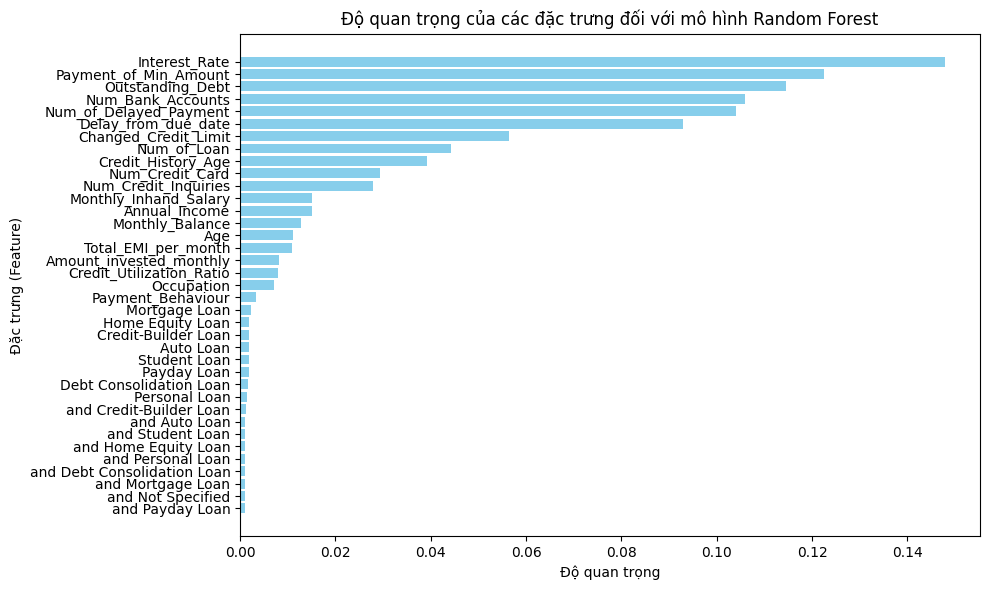

In [ ]:
# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Độ quan trọng')
plt.ylabel('Đặc trưng (Feature)')
plt.title('Độ quan trọng của các đặc trưng đối với mô hình Random Forest')
plt.gca().invert_yaxis()  # Đảo ngược trục y để đặc trưng quan trọng nhất ở trên
plt.tight_layout()
plt.show()

Phân cum khách hàng tiềm năng để cho vay

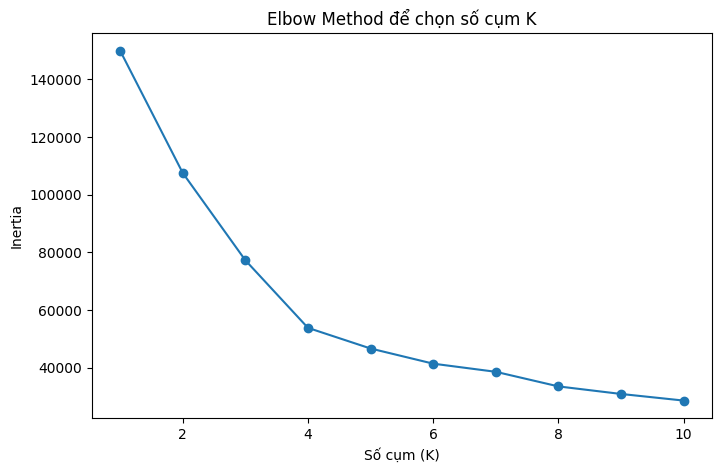

In [ ]:
df = data_full

credit_cols = [
    'Monthly_Balance',
    'Amount_invested_monthly',
    'Total_EMI_per_month'
]

credit_data = df[credit_cols].copy()

# Xử lý missing (nếu có)
credit_data.fillna(credit_data.mean(), inplace=True)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
credit_scaled = scaler.fit_transform(credit_data)

# Xác định số cụm bằng Elbow
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(credit_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Số cụm (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method để chọn số cụm K')
plt.show()



In [ ]:
#  Áp dụng KMeans++
optimal_k = 4  # chỉnh nếu sau khi xem Elbow
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(credit_scaled)

# Gắn nhãn cụm vào DataFrame
df['Credit_Risk_Cluster'] = clusters

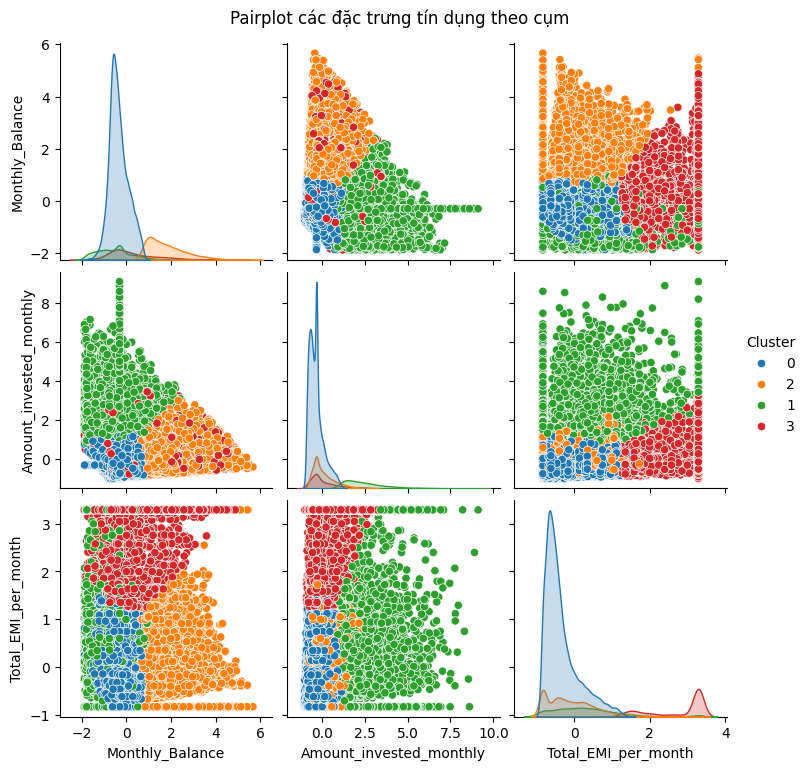

In [ ]:

# Thêm nhãn cụm vào data chuẩn hóa để plot
credit_plot = pd.DataFrame(credit_scaled, columns=credit_cols)
credit_plot['Cluster'] = df['Credit_Risk_Cluster'].astype(str)

# Plot pairplot
sns.pairplot(credit_plot, hue='Cluster', diag_kind='kde', palette='tab10')
plt.suptitle('Pairplot các đặc trưng tín dụng theo cụm', y=1.02)
plt.show()


 cụm 0 (Xanh dương)
Có Monthly_Balance khá thấp, phân bố sát bên trái đồ thị → nhiều cá nhân có số dư thấp.
Amount_invested_monthly và Total_EMI_per_month cũng rất thấp → nhóm khách hàng có tiềm lực tài chính yếu, ít đầu tư và trả góp nhỏ.
Đại diện cho nhóm có thu nhập thấp, rủi ro tín dụng cao.

Cụm 1 (Xanh lá cây)
Monthly_Balance trải dài từ trung bình đến cao.
Amount_invested_monthly phân bố khá rộng, nhiều điểm dữ liệu với đầu tư cao.
Total_EMI_per_month trung bình đến cao.
Là nhóm có tài chính ổn định, đầu tư nhiều hơn và có khả năng thanh toán EMI cao hơn → tiềm năng tốt cho tín dụng.

Cụm 2 (Cam)
Monthly_Balance cao, nhưng Amount_invested_monthly và Total_EMI_per_month ở mức trung bình thấp.
Đây là nhóm có thu nhập nhưng không đầu tư nhiều và ít vay mượn.
Là nhóm ưu tiên tiết kiệm hơn là chi tiêu.

Cụm 3 (Đỏ)
Total_EMI_per_month rất cao, nằm riêng biệt về phía bên phải đồ thị.
Amount_invested_monthly rất thấp, và Monthly_Balance cũng không cao.
Nhóm này là những người đang gánh nặng nợ cao, trả góp lớn nhưng không đầu tư hay tích luỹ → rủi ro tín dụng cao.


In [ ]:
# Bản đồ ánh xạ cụm số sang tên cụm
cluster_labels = {
    0: 'tài chính yếu, ít đầu',
    1: 'tài chính ổn định, đầu tư nhiều',
    2: 'không đầu tư nhiều và ít vay mượn',
    3: 'nợ cao, không đầu tư tích luỹ'
}

# Thêm cột mới 'Cluster_Label' vào DataFrame
data_full['Cluster_Label'] = data_full['Credit_Risk_Cluster'].map(cluster_labels)

# Kiểm tra kết quả
print(data_full[['Credit_Risk_Cluster', 'Cluster_Label']].head())

   Credit_Risk_Cluster          Cluster_Label
0                    0  tài chính yếu, ít đầu
1                    0  tài chính yếu, ít đầu
2                    0  tài chính yếu, ít đầu
3                    0  tài chính yếu, ít đầu
4                    0  tài chính yếu, ít đầu


In [ ]:
print(data_full)

        Age  Occupation  Annual_Income  Monthly_Inhand_Salary  \
0      23.0          12       19114.12            1824.843333   
1      24.0          12       19114.12            1824.843333   
2      24.0          12       19114.12            1824.843333   
3      24.0          12       19114.12            1592.843333   
4      28.0          15       34847.84            3037.986667   
...     ...         ...            ...                    ...   
49995  34.0           1       20002.88            1929.906667   
49996  25.0           9       39628.99            3302.415833   
49997  25.0           9       39628.99            3359.415833   
49998  25.0           9       39628.99            3302.415833   
49999  25.0           9       39628.99            3359.415833   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
0                    3.0              4.0            3.0            4   
1                    3.0              4.0            3.0            4   


In [ ]:
print(data_full['Cluster_Label'].unique())

['tài chính yếu, ít đầu' 'không đầu tư nhiều và ít vay mượn'
 'tài chính ổn định, đầu tư nhiều' 'nợ cao, không đầu tư tích luỹ']


In [ ]:
data_full.to_csv('phanloai.csv', encoding='utf-8-sig', index=False)


In [ ]:
files.download('phanloai.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>